In [2]:
# THIS IS THE SETUP CODE
from google.colab import drive
import os

# 1. Mount Google Drive (It will ask for permission)
drive.mount('/content/drive')

# 2. Move to your project folder
# This tells Python: "Work inside the fraud_detection_project folder"
# MAKE SURE THIS PATH MATCHES YOUR FOLDER NAME EXACTLY
project_path = '/content/drive/MyDrive/fraud_detection_project'

try:
    os.chdir(project_path)
    print("SUCCESS: Connected to your Project Folder!")
    print("Here are the files I can see:")
    print(os.listdir('data')) # This checks inside your data folder
except:
    print("ERROR: Could not find the folder. Check your folder name in Google Drive.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
SUCCESS: Connected to your Project Folder!
Here are the files I can see:
['Train-1542865627584.csv', 'Train_Beneficiarydata-1542865627584.csv', 'Train_Outpatientdata-1542865627584.csv', 'Train_Inpatientdata-1542865627584.csv', 'provider_level_dataset.csv', 'final_logistic_regression_model.joblib']


In [4]:
# --- CELL 1: SETUP & LOAD MODEL ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # For loading the model
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    classification_report, roc_curve, precision_recall_curve, auc
)

# 1. Load Data
df = pd.read_csv('data/provider_level_dataset.csv')

# 2. Re-create X and y
if 'Provider' in df.columns:
    X = df.drop(columns=['Provider', 'PotentialFraud'])
else:
    X = df.drop(columns=['PotentialFraud'])

y = df['PotentialFraud'].map({'Yes': 1, 'No': 0}) if df['PotentialFraud'].dtype == 'object' else df['PotentialFraud']

# 3. Re-create Train/Test Split (Must match previous notebooks)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Load the Saved Model
model_filename = 'data/final_logistic_regression_model.joblib'
# Adjust path if you saved it elsewhere (e.g., just 'final_logistic_regression_model.joblib')
try:
    champion_model = joblib.load(model_filename)
    print(f"SUCCESS: Loaded {model_filename}")
except FileNotFoundError:
    print("ERROR: Model file not found. Please upload it or check the path.")

SUCCESS: Loaded data/final_logistic_regression_model.joblib


In [5]:
# --- CELL 2: ROBUSTNESS CHECK (CROSS-VALIDATION) ---

print("Performing 5-Fold Cross-Validation on Training Data...")
print("(This proves the model's stability)")

# Define the CV strategy (Stratified ensures each fold has fraud cases)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calculate scores for Recall (our priority) and ROC-AUC
recall_scores = cross_val_score(champion_model, X_train, y_train, cv=cv, scoring='recall')
roc_scores = cross_val_score(champion_model, X_train, y_train, cv=cv, scoring='roc_auc')

print(f"\nRecall Scores per Fold: {recall_scores}")
print(f"Average Recall: {recall_scores.mean():.4f} (+/- {recall_scores.std()*2:.4f})")

print(f"\nROC-AUC Scores per Fold: {roc_scores}")
print(f"Average ROC-AUC: {roc_scores.mean():.4f} (+/- {roc_scores.std()*2:.4f})")

# If the standard deviation (std) is low (<0.05), your model is ROBUST.

Performing 5-Fold Cross-Validation on Training Data...
(This proves the model's stability)

Recall Scores per Fold: [0.80246914 0.81481481 0.77777778 0.81481481 0.83950617]
Average Recall: 0.8099 (+/- 0.0401)

ROC-AUC Scores per Fold: [0.93111583 0.94015884 0.92312652 0.93310658 0.93587805]
Average ROC-AUC: 0.9327 (+/- 0.0113)


In [6]:
# --- CELL 3: FINAL TEST SET EVALUATION ---

# 1. Generate Predictions on the unseen Test Set
y_pred = champion_model.predict(X_test)
y_prob = champion_model.predict_proba(X_test)[:, 1]

# 2. Calculate All Metrics
results = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_prob),
    "PR-AUC": average_precision_score(y_test, y_prob)
}

# 3. Display Report
print("\n--- FINAL MODEL REPORT CARD (TEST SET) ---")
for metric, score in results.items():
    print(f"{metric:<15}: {score:.4f}")

print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred))


--- FINAL MODEL REPORT CARD (TEST SET) ---
Accuracy       : 0.8946
Precision      : 0.4649
Recall         : 0.8515
F1 Score       : 0.6014
ROC-AUC        : 0.9569
PR-AUC         : 0.7567

--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       981
           1       0.46      0.85      0.60       101

    accuracy                           0.89      1082
   macro avg       0.72      0.88      0.77      1082
weighted avg       0.93      0.89      0.91      1082



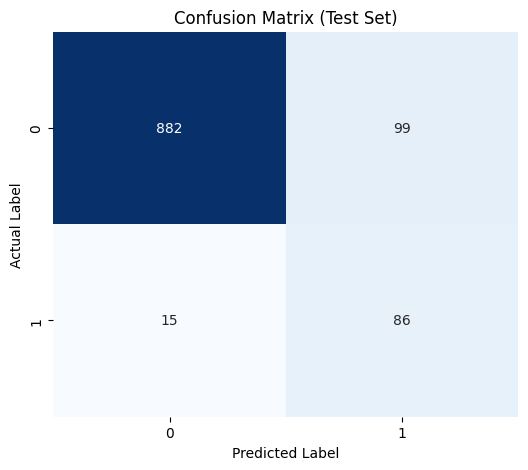


--- BUSINESS IMPACT ANALYSIS ---
Total Fraudsters in Test Set: 101
Potential Loss (No Model):    $10,100,000.00
------------------------------
Fraud Detected (TP):          86
Fraud Missed (FN):            15
False Alarms (FP):            99
------------------------------
Cost of Audits:               $185,000.00
Remaining Fraud Loss:         $1,500,000.00
Total Cost (With Model):      $1,685,000.00
TOTAL SAVINGS:                $8,415,000.00


In [7]:
# --- CELL 4: CONFUSION MATRIX & FINANCIAL IMPACT ---

# 1. Visual Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

# 2. Cost-Benefit Analysis (Hypothetical)
# Assumptions (You can change these numbers!)
AVG_FRAUD_COST = 100000  # How much we lose if we miss a fraudster
AUDIT_COST = 1000        # How much it costs to investigate a doctor

tn, fp, fn, tp = cm.ravel()

# Scenario A: Do Nothing (No Model)
# We lose money on ALL fraud cases in the test set
loss_no_model = (fn + tp) * AVG_FRAUD_COST

# Scenario B: Using Your Model
# We pay to audit everyone flagged (TP + FP)
audit_fees = (tp + fp) * AUDIT_COST
# We still lose money on the fraud we MISSED (FN)
remaining_fraud_loss = fn * AVG_FRAUD_COST
# Total Cost with Model
cost_with_model = audit_fees + remaining_fraud_loss

# Savings
savings = loss_no_model - cost_with_model

print("\n--- BUSINESS IMPACT ANALYSIS ---")
print(f"Total Fraudsters in Test Set: {tp + fn}")
print(f"Potential Loss (No Model):    ${loss_no_model:,.2f}")
print("-" * 30)
print(f"Fraud Detected (TP):          {tp}")
print(f"Fraud Missed (FN):            {fn}")
print(f"False Alarms (FP):            {fp}")
print("-" * 30)
print(f"Cost of Audits:               ${audit_fees:,.2f}")
print(f"Remaining Fraud Loss:         ${remaining_fraud_loss:,.2f}")
print(f"Total Cost (With Model):      ${cost_with_model:,.2f}")
print("=" * 30)
print(f"TOTAL SAVINGS:                ${savings:,.2f}")

In [13]:
# --- CELL 5: ERROR ANALYSIS (CASE STUDY GENERATION) ---

# 1. Create a DataFrame of Predictions
analysis_df = X_test.copy()
analysis_df['Actual_Fraud'] = y_test
analysis_df['Predicted_Fraud'] = y_pred
analysis_df['Prob_Fraud'] = y_prob

# --- FIX: RECOVER PROVIDER ID ---
# We use the index to look up the 'Provider' ID from the original dataframe (df)
analysis_df['Provider'] = df.loc[X_test.index, 'Provider']

# 2. Identify False Positives (Innocent but flagged)
# Actual = 0, Predicted = 1
fp_cases = analysis_df[(analysis_df['Actual_Fraud'] == 0) & (analysis_df['Predicted_Fraud'] == 1)]
print(f"Found {len(fp_cases)} False Positives. Showing top 3 with highest risk scores:")

# Display Provider ID along with key stats
cols_to_show = ['Provider', 'Prob_Fraud', 'TotalReimbursed', 'NumClaims', 'InpatientShare']
display(fp_cases[cols_to_show].sort_values(by='Prob_Fraud', ascending=False).head(3))

# 3. Identify False Negatives (Fraud but missed)
# Actual = 1, Predicted = 0
fn_cases = analysis_df[(analysis_df['Actual_Fraud'] == 1) & (analysis_df['Predicted_Fraud'] == 0)]
print(f"\nFound {len(fn_cases)} False Negatives. Showing top 3 with lowest risk scores:")

# Display Provider ID along with key stats
display(fn_cases[cols_to_show].sort_values(by='Prob_Fraud', ascending=True).head(3))

# 4. Compare Averages to understand WHY
print("\n--- BEHAVIORAL COMPARISON ---")
print("Why does the model get confused?")
comparison = pd.DataFrame({
    'Legitimate (True Neg)': analysis_df[(analysis_df['Actual_Fraud']==0) & (analysis_df['Predicted_Fraud']==0)].mean(numeric_only=True),
    'False Positives (Innocent flagged)': fp_cases.mean(numeric_only=True),
    'False Negatives (Fraud missed)': fn_cases.mean(numeric_only=True),
    'Caught Fraud (True Pos)': analysis_df[(analysis_df['Actual_Fraud']==1) & (analysis_df['Predicted_Fraud']==1)].mean(numeric_only=True)
})
display(comparison)

Found 99 False Positives. Showing top 3 with highest risk scores:


,Provider,Prob_Fraud,TotalReimbursed,NumClaims,InpatientShare
3932,PRV55916,0.999999,1311040,127,0.905512
361,PRV51456,0.999969,1038990,135,0.829630
852,PRV52063,0.999943,1116210,792,0.111111



Found 15 False Negatives. Showing top 3 with lowest risk scores:


,Provider,Prob_Fraud,TotalReimbursed,NumClaims,InpatientShare
5324,PRV57667,0.191209,20000,3,1.000000
5248,PRV57569,0.196482,57940,73,0.068493
2812,PRV54505,0.223464,55140,38,0.131579



--- BEHAVIORAL COMPARISON ---
Why does the model get confused?


,Legitimate (True Neg),False Positives (Innocent flagged),False Negatives (Fraud missed),Caught Fraud (True Pos)
NumClaims,52.485261,280.646465,130.133333,671.488372
NumUniqueBeneficiaries,38.633787,172.808081,66.800000,372.558140
TotalReimbursed,28174.501134,291300.707071,86570.000000,821857.209302
AvgClaimAmount,1197.511136,4572.758960,2689.454222,3705.377056
AvgClaimDuration,2.817055,4.240705,4.224817,3.947423
AvgHospitalDuration,0.522765,2.258115,1.993813,2.015711
AvgAge,72.734272,72.999892,72.863627,72.658503
AdmissionRate,0.097978,0.327294,0.204453,0.331411
NumInpatientClaims,1.452381,21.040404,5.200000,64.372093
NumOutpatientClaims,51.032880,259.606061,124.933333,607.116279
